In [1]:
%pylab inline
import datetime as dt
import os
import numpy as np
import pylab as pl
import pandas as pd
import scipy.stats as stats
import wradlib as wrl

# Plotting settings
import matplotlib.dates as mdates
pl.rcParams['mathtext.fontset'] = 'custom'
pl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
pl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
pl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

colorBlue = '#08519c'
colorDarkGrey = '#252525'
colorDarkPink = '#dd1c77'

Populating the interactive namespace from numpy and matplotlib


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from palettable.cartocolors.sequential import Teal_7, DarkMint_7
import pyart

In [7]:
import io_func_PH
import util_func_PH

# Define functions

In [8]:
def get_swath(pr_lon,pr_lat):
    x1 = np.mean(pr_lon,axis=1)[0]
    y1 = np.mean(pr_lat,axis=1)[0]

    x2 = np.mean(pr_lon,axis=1)[-1]
    y2 = np.mean(pr_lat,axis=1)[-1]

    x3,y3 = pr_lon[0][0], pr_lat[0][0]
    x4,y4 = pr_lon[-1][0], pr_lat[-1][0]

    x5,y5 = pr_lon[0][-1], pr_lat[0][-1]
    x6,y6 = pr_lon[-1][-1], pr_lat[-1][-1]
    
    return x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6

# Read shapefile and set parameters

In [9]:
shpfile = '../data/GIS/Country.shp'
dataset, inLayer = wrl.io.open_shape(shpfile)
borders, keys = wrl.georef.get_shape_coordinates(inLayer)

lon0_gr = 120.363746643
lat0_gr = 14.8221387863

wgs84 = wrl.georef.get_default_projection()
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' + 
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))

In [10]:
borders_rad = np.zeros_like(borders)
for i in range(len(borders)):
    borders_rad[i] = wrl.georef.reproject(borders[i], projection_source=wgs84, projection_target=rad )

# Read data

In [31]:
filename = '../output/matching/trmm_sub_20131108_100705.hdf5'
df_ = pd.read_hdf(filename, 'dataframe')

In [32]:
df_.keys()

Index(['sample_id', 'sr_date', 'gr_date', 'time_diff', 'ee', 'elev', 'sr_ref',
       'sr_ref_ss', 'sr_ref_sh', 'gr_ref', 'gr_ref_ku', 'lat', 'lon', 'alt',
       'quality_BBF', 'pflag', 'ptype', 'bb', 'ratio_sr', 'ratio_gr'],
      dtype='object')

In [33]:
print('Length db: {0}'.format(len(df_)))

Length db: 1089


# Read PR data (for plotting swath lines only)

In [34]:
gpm_filepath = '../data/gpm'
gpm_file = os.path.join(gpm_filepath, '2A-PH-SUBTAG.GPM.Ku.V7-20170308.20151001-S185850-E185953.009041.V05A.HDF5')

trmm_filepath = '../data/trmm'
trmm_file_2a23 = '2A-PH-SUBTAG.TRMM.PR.2A23.20131108-S100701-E100811.091030.7.HDF'
trmm_file_2a25 = '2A-PH-SUBTAG.TRMM.PR.2A25.20131108-S100701-E100811.091030.7.HDF'

In [35]:
platf = 'trmm'
# read spaceborn PR data
if platf == "gpm":
    pr_data = io_func_PH.read_gpm(gpm_file)
elif platf == "trmm":
    pr_file_2a23 = os.path.join(trmm_filepath, trmm_file_2a23)
    pr_file_2a25 = os.path.join(trmm_filepath, trmm_file_2a25)
    pr_data = io_func_PH.read_trmm_gdal(pr_file_2a23, pr_file_2a25)
else:
    raise("Invalid platform")

In [36]:
# Longitudes of PR scans
pr_lon = pr_data['lon']
# Latitudes of PR scans
pr_lat = pr_data['lat']
pr_x, pr_y = wrl.georef.reproject(pr_lon, pr_lat, 
                                      projection_source=wgs84, 
                                      projection_target=rad)

In [37]:
# get swath points
x1,x2,x3,x4,x5,x6,y1,y2,y3,y4,y5,y6 = get_swath(pr_x/1000., pr_y/1000.)

# Process Data

## Apply filters

In [38]:
# calculate the distance of each point
df_['r_dist'] = np.sqrt(df_.lat**2 + df_.lon**2)

In [40]:
# apply the filters
df_sub = df_.loc[(df_.pflag > 100) 
                 & (df_.ratio_gr >= 0.7) & (df_.ratio_sr >= 0.7) 
                 & ((df_.bb < 0.0) | (df_.bb > 1.0)) 
                 & (df_.time_diff.values <= 300)
                 & (df_.r_dist > 15000) & (df_.r_dist < 115000)]               

In [41]:
df_sub = df_sub.sort_values('gr_date')

## Select an elevation angle

In [44]:
elevangle = 0.5

In [45]:
df_sample = df_sub.loc[(df_sub.elev == elevangle)]

In [46]:
pr_before = df_sample['sr_ref']
gr_before = df_sample['gr_ref']

qualBBF = df_sample['quality_BBF']

In [47]:
pr_before = numpy.array(pr_before)
gr_before = numpy.array(gr_before)
qualBBF = numpy.array(qualBBF)
inds = qualBBF.argsort()
pr_before_sorted = pr_before[inds]
gr_before_sorted = gr_before[inds]
qualBBF_sorted = qualBBF[inds]

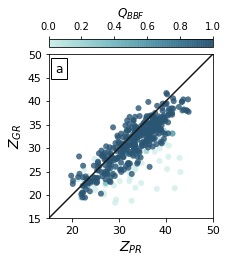

In [48]:
fig = pl.figure(figsize=(10,4.5))

ax1 = fig.add_subplot(131,aspect='equal')
pm1 = ax1.scatter(pr_before_sorted,gr_before_sorted, alpha=0.8,c=qualBBF_sorted, 
            cmap=Teal_7.mpl_colormap,edgecolor='None',vmin=0)     # plot before
ax1.set_axis_bgcolor('White')
ax1.plot([0,60],[0,60], linestyle="solid", color="0.1")
ax1.set_xlim(15,50)
ax1.set_ylim(15,50)
ax1.set_xlabel('$Z_{PR}$', fontsize=14)
ax1.set_ylabel('$Z_{GR}$', fontsize=14)
ax1.tick_params(labelsize=11)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("top", size="5%", pad=0.1)
cb1 = fig.colorbar(pm1, cax=cax1, orientation="horizontal")
cb1.set_label('$Q_{BBF}$', fontsize=12)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.xaxis.set_label_position('top')
#cb1.ax.xaxis.set_ticklabels(['0.0','','0.2','','0.4','','0.6','','0.8','','1.0'])
ax1.annotate("a", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))

pl.subplots_adjust(wspace=0.2)
#pl.savefig('scatter_with_withoutmask_BBF_POD_VOL_'+datestr+'.png', dpi=600, bbox_inches='tight')

## Plot the quality indices

In [49]:
x = df_sample['lon']/1000.
y = df_sample['lat']/1000.

In [51]:
#refpr1 = df_sample.sr_ref # uncorrected
refpr1 = df_sample.sr_ref_ss # corrected Ku to S-band (snow)
refgr1 = df_sample.gr_ref

In [52]:
deltaZ = refgr1-refpr1

In [53]:
bias = np.mean(deltaZ)
bias_w = np.average(deltaZ, weights = np.ma.masked_invalid(df_sample.quality_BBF))

std = np.std(deltaZ)
std_w = np.sqrt(np.average((deltaZ-bias)**2, weights=np.ma.masked_invalid(df_sample.quality_BBF)))

In [54]:
print('Simple bias:{0}'.format(bias))
print('Weighted bias (BBF):{0}'.format(bias_w))

print('Simple std:{0}'.format(std))
print('Weighted std (BBF):{0}'.format(std_w))

Simple bias:-1.8833175872194787
Weighted bias (BBF):-1.212239290462
Simple std:3.3523828257914787
Weighted std (BBF):2.596823980514323


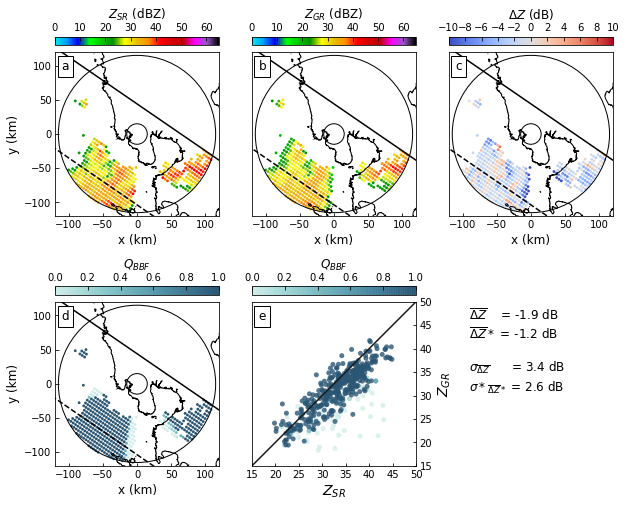

In [55]:
fig = pl.figure(figsize=(10,8))

ax1 = fig.add_subplot(2,3,1, aspect='equal')
c1 = pl.Circle((0,0), radius=115, color='k', fill=False)
c2 = pl.Circle((0,0), radius=15, color='k', fill=False)
ax1.add_artist(c1)
ax1.add_artist(c2)
pm1 = pl.scatter(x, y, c=refpr1, cmap=pyart.graph.cm.NWSRef, vmin=0, vmax=65, edgecolor="None", s=8)
wrl.vis.add_lines(ax1, borders_rad/1000., color='black', lw=1.)
ax1.set_xlim((-120,120))
ax1.set_ylim((-120,120))
ax1.set_xlabel('x (km)', fontsize=12)
ax1.set_ylabel('y (km)', fontsize=12)
pl.plot((x1,x2),(y1,y2),'k--') # centerline
pl.plot((x3,x4),(y3,y4),'k-')
pl.plot((x5,x6),(y5,y6),'k-')
# colorbar
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("top", size="5%", pad=0.1)
cb = fig.colorbar(pm1, cax=cax1, orientation="horizontal")
cb.set_label('$Z_{SR}$ (dBZ)', fontsize=12)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
ax1.tick_params(direction='in')
cb.ax.tick_params(direction='in')

ax2 = fig.add_subplot(2,3,2, aspect='equal')
pm2 = pl.scatter(x, y, c=refgr1, cmap=pyart.graph.cm.NWSRef, vmin=0, vmax=65, edgecolor="None", s=8)
wrl.vis.add_lines(ax2, borders_rad/1000., color='black', lw=1.)
c1 = pl.Circle((0,0), radius=115, color='k', fill=False)
c2 = pl.Circle((0,0), radius=15, color='k', fill=False)
ax2.add_artist(c1)
ax2.add_artist(c2)
ax2.set_xlim((-120,120))
ax2.set_ylim((-120,120))
ax2.set_xlabel('x (km)', fontsize=12)
ax2.get_yaxis().set_ticks([])
pl.plot((x1,x2),(y1,y2),'k--') # centerline
pl.plot((x3,x4),(y3,y4),'k-')
pl.plot((x5,x6),(y5,y6),'k-')
# colorbar
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("top", size="5%", pad=0.1)
cb = fig.colorbar(pm2, cax=cax2, orientation="horizontal")
cb.set_label('$Z_{GR}$ (dBZ)', fontsize=12)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
ax2.tick_params(direction='in')
cb.ax.tick_params(direction='in')

ax3 = fig.add_subplot(2,3,3, aspect='equal')
pm3 = pl.scatter(x, y, c=(refgr1-refpr1), cmap=pl.cm.coolwarm, vmin=-10, vmax=10, edgecolor="None", s=8)
wrl.vis.add_lines(ax3, borders_rad/1000., color='black', lw=1.)
c1 = pl.Circle((0,0), radius=115, color='k', fill=False)
c2 = pl.Circle((0,0), radius=15, color='k', fill=False)
ax3.add_artist(c1)
ax3.add_artist(c2)
ax3.set_xlim((-120,120))
ax3.set_ylim((-120,120))
ax3.set_xlabel('x (km)', fontsize=12)
ax3.get_yaxis().set_ticks([])
pl.plot((x1,x2),(y1,y2),'k--') # centerline
pl.plot((x3,x4),(y3,y4),'k-')
pl.plot((x5,x6),(y5,y6),'k-')
# colorbar
div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("top", size="5%", pad=0.1)
cb = fig.colorbar(pm3, cax=cax3, orientation="horizontal", ticks=range(-10,11,2))
cb.set_label('$\Delta Z$ (dB)', fontsize=12)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
ax3.tick_params(direction='in')
cb.ax.tick_params(direction='in')

ax4 = fig.add_subplot(2,3,4, aspect='equal')
pm4 = pl.scatter(x, y, c=df_sample.quality_BBF, cmap=Teal_7.mpl_colormap, vmin=0, vmax=1, edgecolor="None", s=8)
wrl.vis.add_lines(ax4, borders_rad/1000., color='black', lw=1.)
c1 = pl.Circle((0,0), radius=115, color='k', fill=False)
c2 = pl.Circle((0,0), radius=15, color='k', fill=False)
ax4.add_artist(c1)
ax4.add_artist(c2)
ax4.set_xlim((-120,120))
ax4.set_ylim((-120,120))
ax4.set_xlabel('x (km)', fontsize=12)
ax4.set_ylabel('y (km)', fontsize=12)
pl.plot((x1,x2),(y1,y2),'k--') # centerline
pl.plot((x3,x4),(y3,y4),'k-')
pl.plot((x5,x6),(y5,y6),'k-')
# colorbar
div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes("top", size="5%", pad=0.1)
cb = fig.colorbar(pm4, cax=cax4, orientation="horizontal")
cb.set_label('$Q_{BBF}$', fontsize=12)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
ax4.tick_params(direction='in')
cb.ax.tick_params(direction='in')

ax5 = fig.add_subplot(2,3,5,aspect='equal')
pm5 = ax5.scatter(pr_before_sorted,gr_before_sorted, alpha=0.8,c=qualBBF_sorted, 
            cmap=Teal_7.mpl_colormap,edgecolor='None',vmin=0, s=25)     # plot before
ax5.set_axis_bgcolor('White')
ax5.plot([0,60],[0,60], linestyle="solid", color="0.1")
ax5.set_xlim(15,50)
ax5.set_ylim(15,50)
ax5.set_xticks(range(15,51,5))
ax5.set_xlabel('$Z_{SR}$', fontsize=14)
ax5.set_ylabel('$Z_{GR}$', fontsize=14)
ax5.yaxis.set_label_position('right')
ax5.yaxis.set_ticks_position('right')
div5 = make_axes_locatable(ax5)
cax5 = div5.append_axes("top", size="5%", pad=0.1)
cb5 = fig.colorbar(pm5, cax=cax5, orientation="horizontal")
cb5.set_label('$Q_{BBF}$', fontsize=12)
cb5.ax.xaxis.set_ticks_position('top')
cb5.ax.xaxis.set_label_position('top')
ax5.tick_params(direction='in')
cb5.ax.tick_params(direction='in')

ax6 = fig.add_subplot(2,3,6,aspect='equal')
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.axis('off')

ax1.annotate("a", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))
ax2.annotate("b", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))
ax3.annotate("c", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))
ax4.annotate("d", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))
ax5.annotate("e", fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.04, 0.89), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='black'))

text7a = "$ \overline{{\Delta Z}}$    = {:0.1f} dB".format(bias)
text7b = "$ \overline{{\Delta Z}}*$ = {:0.1f} dB".format(bias_w)
text7c = "$ \sigma _{{\overline{{\Delta Z}}}}$      = {:0.1f} dB".format(std)
text7d = "$ \sigma* _{{\overline{{\Delta Z}}*}}$ = {:0.1f} dB".format(std_w)
text7 = text7a + '\n' + text7b + '\n\n' + text7c + '\n' + text7d
ax6.annotate(text7, fontsize=12,
            xy=(0.04, 0.89), xycoords='axes fraction',
            xytext=(0.12, 0.4), textcoords='axes fraction',
            bbox=dict(facecolor='white', edgecolor='None'))

pl.subplots_adjust(wspace=0.2, hspace=0.35)
#pl.tight_layout()
#pl.savefig('all_plots_'+datestr+'_'+str(elevangle)+'.png', dpi=300, bbox_inches='tight')